In [170]:
from jaxgp.kernels import RBF
from jaxgp.regression import ExactGPRGrad, ExactGPR
from jaxgp.utils import Logger

import jax.numpy as jnp
import numpy as onp

import matplotlib.pyplot as plt

import LJ_gp

In [171]:
Temp = 1.2
N_A = 6.02214076e23

flag_box = ["AA","AB","BB"]
data = onp.loadtxt("./LJ_S0_data_sum.txt") # 7 columns: X_A S_AA S_AA_err S_AB S_AB_err S_BB S_BB_err

# Rename every var
# mol frac of A paricles 
X_A  = data[:,0] 
# X_A = N_A/(N_A + N_B), where N_A is the number of partilce A, N_B is the number of partilce B; 
# also, X_A = c_A/C_all, as mentioned below though;
# N_A + N_B = 23328 in this dataset;

# for the structure factor S, save the data as a (2, N) array, the first coloumn is the value, while the second one is its error. 
S_AA = data[:,1]
S_AA_err = data[:,2]
S_AB = data[:,3]
S_AB_err = data[:,4]
S_BB = data[:,5]
S_BB_err = data[:,6]

#compute the concentrition
vol_list = ['46740.536', '46702.929', '46940.069', '46777.225', '46868.228', '46810.31', '47000.639', '46841.816', '46963.354', '46963.354', '47068.412', '47096.167', '47135.511', '47109.139', '47192.731', '47216.936', '47328.919', '47378.922', '47148.088', '47378.351', '47316.911']
vol_sys = jnp.array(list((map(float, vol_list))))
c_all = jnp.array((1/N_A*23328)/(vol_sys*1e-27)/100) #23328, the total number of toms in the system
c_A_mol_L = jnp.array((X_A/N_A*23328)/(vol_sys*1e-27)/100)
c_B_mol_L = c_all - c_A_mol_L

# plt.errorbar(X_A, S_AA[:,0], S_AA[:,1], ls="", marker="o", label="$S_{AA}$")
# plt.errorbar(X_A, S_AB[:,0], S_AB[:,1], ls="", marker="o", label="$S_{AB}$")
# plt.errorbar(X_A, S_BB[:,0], S_BB[:,1], ls="", marker="o", label="$S_{BB}$")
# plt.ylabel("$S_0$")  
# plt.xlabel("$X_{A}$") 

# plt.legend()
# plt.show()

In [172]:
print(LJ_gp.mean_err(S_AA_err))
print(LJ_gp.mean_err(S_AB_err))
print(LJ_gp.mean_err(S_BB_err))

0.0025987553134474454
0.0021247715393592336
0.0025912547332879667


In [173]:
def integrand_normal(ca, cb, saa, sab):
    term = 1. / (saa - sab*jnp.sqrt(ca/cb)) - 1
    return term / ca

def integrand_log(ca, cb, saa, sab):
    return 1. / (saa - sab*jnp.sqrt(ca/cb)) - 1

In [174]:
saa = jnp.array(S_AA)[1:-1]
sab = jnp.array(S_AB)[1:-1]
sbb = jnp.array(S_BB)[1:-1]
ca = c_A_mol_L[1:-1]
cb = c_B_mol_L[1:-1]

In [175]:
from jaxgp import Optimizer

# kernel = RBF(len(ca)+1)
kernel = RBF()
# noise = jnp.ones((19,))*2.5e-3
noise = jnp.ones((19,))*1e-2
noise = jnp.hstack((jnp.zeros(1), noise))

optimizer = Optimizer.SLSQP

logger_A = Logger()
logger_B = Logger()

## Predict $\mu_A^{ex}$

In [176]:
# X_train = (jnp.zeros((1,1)), ca.reshape(-1,1))
# Y_train = integrand_normal(ca, cb, saa, sab)*Temp
# Y_train = jnp.hstack((jnp.zeros(1), Y_train))

X_train = (jnp.zeros((1,1)), jnp.log(ca).reshape(-1,1))
Y_train = integrand_log(ca, cb, saa, sab)*Temp
Y_train = jnp.hstack((jnp.zeros(1), Y_train))

In [177]:
jnp.std(Y_train)

DeviceArray(0.01059072, dtype=float32)

In [178]:
model = ExactGPR(kernel, noise=noise, logger=logger_A, optimize_method=optimizer)

In [179]:
model.train(X_train, Y_train)

True


In [180]:
eval_grid = jnp.log(ca)

mean, std = model.eval(eval_grid.reshape(-1,1))
mu_a = mean.reshape(-1)
mu_a_err = std.reshape(-1)

## Predict $\mu_B^{ex}$

In [181]:
# X_train = (jnp.zeros((1,1)), cb.reshape(-1,1))
# Y_train = integrand_normal(cb, ca, sbb, sab)*Temp
# Y_train = jnp.hstack((jnp.zeros(1), Y_train))

X_train = (jnp.zeros((1,1)), jnp.log(cb).reshape(-1,1))
Y_train = integrand_log(cb, ca, sbb, sab)*Temp
Y_train = jnp.hstack((jnp.zeros(1), Y_train))

In [182]:
model = ExactGPR(kernel, noise=noise, logger=logger_B, optimize_method=optimizer)

In [183]:
model.train(X_train, Y_train)

True


In [184]:
eval_grid = jnp.log(cb)

mean, std = model.eval(eval_grid.reshape(-1,1))
mu_b = mean.reshape(-1)
mu_b_err = std.reshape(-1)

Text(0, 0.5, '$\\mu^{ex}$')

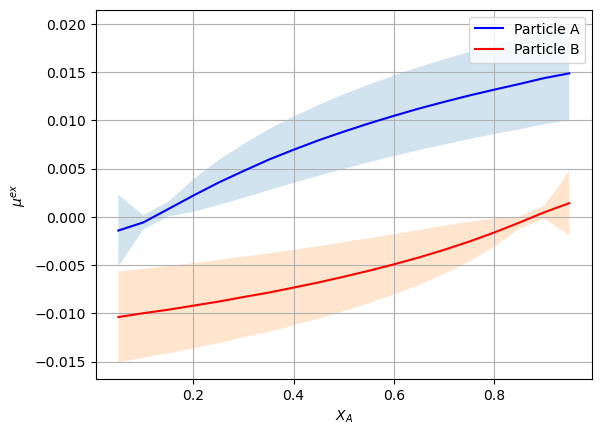

In [185]:
plt.plot(X_A[1:-1], mu_a, c="b", label="Particle A")
plt.fill_between(X_A[1:-1], mu_a-mu_a_err, mu_a+mu_a_err, alpha=0.2)

plt.plot(X_A[1:-1], mu_b, c="r", label="Particle B")
plt.fill_between(X_A[1:-1], mu_b-mu_b_err, mu_b+mu_b_err, alpha=0.2)

plt.grid()
plt.legend()

plt.xlabel("$X_A$")
plt.ylabel("$\mu^{ex}$")

In [186]:
logger_A.iters_list

[DeviceArray([0.6931472, 0.6931472], dtype=float32),
 DeviceArray([0.3470297, 2.5047562], dtype=float32),
 DeviceArray([1.000000e-03, 2.723451e+00], dtype=float32),
 DeviceArray([1.0000003e-03, 2.7345674e+00], dtype=float32),
 DeviceArray([1.0000000e-03, 2.7886744e+00], dtype=float32),
 DeviceArray([1.000000e-03, 3.024747e+00], dtype=float32),
 DeviceArray([1.0000000e-03, 3.2312803e+00], dtype=float32),
 DeviceArray([1.0000000e-03, 3.2966328e+00], dtype=float32),
 DeviceArray([1.000000e-03, 3.309201e+00], dtype=float32),
 DeviceArray([1.000000e-03, 3.309201e+00], dtype=float32)]

In [187]:
logger_B.iters_list

[DeviceArray([0.6931472, 0.6931472], dtype=float32),
 DeviceArray([0.3415659, 2.5884566], dtype=float32),
 DeviceArray([1.0000000e-03, 2.7796264e+00], dtype=float32),
 DeviceArray([1.0000000e-03, 2.7905662e+00], dtype=float32),
 DeviceArray([1.000001e-03, 2.844299e+00], dtype=float32),
 DeviceArray([1.0000000e-03, 3.0904467e+00], dtype=float32),
 DeviceArray([1.0000006e-03, 3.5732837e+00], dtype=float32),
 DeviceArray([1.0000000e-03, 3.8395593e+00], dtype=float32),
 DeviceArray([1.0000000e-03, 3.9984899e+00], dtype=float32),
 DeviceArray([1.000000e-03, 4.053519e+00], dtype=float32),
 DeviceArray([1.000000e-03, 4.053519e+00], dtype=float32)]

In [188]:
jnp.savez("gp_predict_LJ.npz", mu_a=mu_a, mu_a_err=mu_a_err, mu_b=mu_b, mu_b_err=mu_b_err)